In [8]:
# import preprocessing.py functions
import sys
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import time

# Dynamically add the 'src' directory to the Python path
src_path = './src'

if src_path not in sys.path and os.path.exists(src_path):
	sys.path.append(src_path)

# Ensure the path to the 'src' directory is correctly added
from preprocessing.preprocessing import resampling, preprocess, select_HVG
from pipeline.pipelines import xgboost_pipeline

# /!\ Because we import functions from other sources we need to restart kernel to see changes

In [2]:
# Import the required functions from the problem module
from problem import get_train_data, get_test_data

# Load the training and testing data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [9]:
class Classifier(object):
    def __init__(self, **kwargs):
        # Use scikit-learn's pipeline
        self.pipe = xgboost_pipeline(scaler=kwargs.get('scaler'), 
                                     pca_n_components=kwargs.get('pca_n_components'),
                                     max_depths=kwargs.get('max_depths'),
                                     max_features=kwargs.get('max_features'))
        
        self.kwargs = kwargs

    def fit(self, X_sparse, y):
        X, y = resampling(X_sparse, y, method=self.kwargs.get('resampling_method', 'none'))
        X = preprocess(X, method=self.kwargs.get('preprocessing_method', 'none'))
        self.pipe.fit(X, y)

        pass

    def predict_proba(self, X_sparse):
        X = preprocess(X_sparse, method=self.kwargs.get('preprocessing_method', 'none'))
        return self.pipe.predict_proba(X)
    
    def predict(self, X_sparse):
        X = preprocess(X_sparse, method=self.kwargs.get('preprocessing_method', 'none'))
        return self.pipe.predict(X)


In [ ]:
import numpy as np

scaler_options = [True, False]
pca_n_components_options = [20, 50, 100]
max_depths_options = [4, 6, 8]
max_features_options = [0.1, 0.5, 1.0]
resampling_methods = ['none', 'random', 'smote', 'borderline_smote'] #'adasyn' doesn't work
preprocessing_methods = ['none', 'log', 'normalize']

# Grid search over hyperparameters
best_accuracy = 0
best_params = {}

for scaler in scaler_options:
    for pca_n_components in pca_n_components_options:
        for max_depths in max_depths_options:
            for max_features in max_features_options:
                for resampling_method in resampling_methods:
                    for preprocessing_method in preprocessing_methods:

                        clf = Classifier(scaler=scaler,
                                         pca_n_components=pca_n_components,
                                         max_depths=max_depths,
                                         max_features=max_features,
                                         resampling_method=resampling_method,
                                         preprocessing_method=preprocessing_method)
                        try:
                            time_start = time.time()
                            clf.fit(X_train, y_train) # training
                            time_end = time.time()
                            fitting_time = time_end - time_start

                            accuracy = balanced_accuracy_score(y_test, clf.predict(X_test))
                            
                            if accuracy > best_accuracy:
                                best_accuracy = accuracy
                                best_params = {
                                    'scaler': scaler,
                                    'pca_n_components': pca_n_components,
                                    'max_depths': max_depths,
                                    'max_features': max_features,
                                    'resampling_method': resampling_method,
                                    'preprocessing_method': preprocessing_method
                                }
                        except Exception as e:
                            accuracy = 0  # In case of failure, set accuracy to 0
                            fitting_time = 0  # In case of failure, set fitting time to 0
                        # put reults in a log file
                        open("grid_search_log.txt", "a").write(f"Params: scaler = {scaler}, pca_n_components = {pca_n_components}, max_depths = {max_depths}, max_features = {max_features}, resampling_method = {resampling_method}, preprocessing_method = {preprocessing_method} => Accuracy: {accuracy}, Fitting time: {fitting_time:.2f} seconds\n")
                        #print(f"Params: {scaler}, {pca_n_components}, {max_depths}, {max_features}, {resampling_method}, {preprocessing_method} => Accuracy: {accuracy}, Fitting time: {fitting_time:.2f} seconds")
print(f"Best Accuracy: {best_accuracy} with params: {best_params}")
open("grid_search_log.txt", "a").write(f"Best Accuracy: {best_accuracy} with params: {best_params}\n")


In [ ]:



clf = Classifier(scaler=False, 
                 pca_n_components=50,
                 max_depths=6,
                 max_features=1.0,
                 resampling_method='smote',
                 preprocessing_method='log')
clf.fit(X_train, y_train)

y_tr_pred = clf.predict(X_train)
y_te_pred = clf.predict(X_test)

Train balanced accuracy : 1.000
Test balanced accuracy : 0.782


Text(0.5, 1.0, 'Confusion matrix on test set')

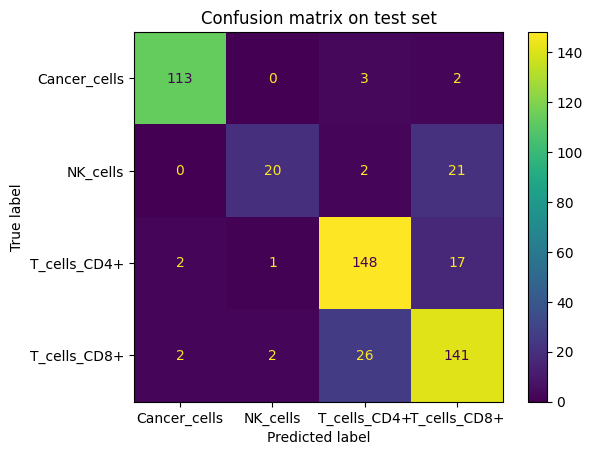

In [ ]:
# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set")

In [ ]:
!ramp-test --submission xgboost_classifier